Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy on validation set: 0.49531152379516125


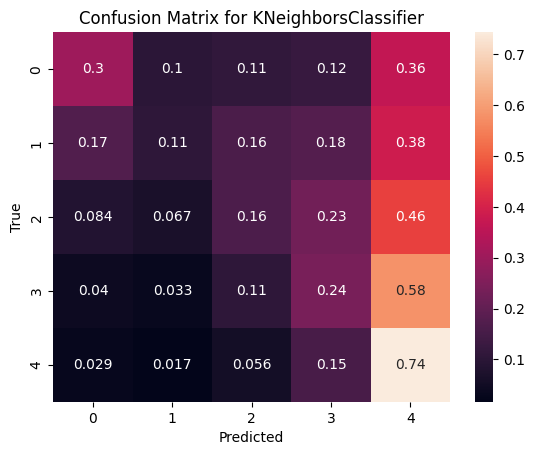

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from os.path import exists

from google.colab import drive
drive.mount('/content/drive')

# Load Data and Save Submission Rows Separately
data = pd.read_csv("/content/drive/MyDrive/CS506/Midterm/train.csv")
submission_rows = pd.read_csv("/content/drive/MyDrive/CS506/Midterm/test.csv")

# Filter and Downsample Training Data
train_data = data.dropna(subset=['Score'])
train_data = train_data.sample(frac=0.1, random_state=0)  # Resample to 10% for efficient processing

# Feature Extraction Function
def add_features_to(df):
    # Calculate Helpfulness score
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Text-based features
    df['TextLength'] = df['Text'].apply(lambda x: len(str(x)))
    df['WordCount'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['AverageWordLength'] = df['Text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if x else 0)
    df['ExclamationCount'] = df['Text'].apply(lambda x: str(x).count('!'))
    df['QuestionCount'] = df['Text'].apply(lambda x: str(x).count('?'))
    df['UpperCaseWordCount'] = df['Text'].apply(lambda x: sum(1 for word in str(x).split() if word.isupper()))

    positive_words = ['good', 'great', 'excellent', 'amazing', 'love', 'wonderful']
    negative_words = ['bad', 'poor', 'terrible', 'awful', 'hate', 'worst']

    df['PositiveWordCount'] = df['Text'].apply(lambda x: sum(word in positive_words for word in str(x).lower().split()))
    df['NegativeWordCount'] = df['Text'].apply(lambda x: sum(word in negative_words for word in str(x).lower().split()))
    df['SentimentShift'] = abs(df['PositiveWordCount'] - df['NegativeWordCount'])

    # Intensity features
    df['ElongatedWordCount'] = df['Text'].apply(lambda x: sum(1 for word in str(x).split() if len(set(word)) < len(word)))
    #df['RepeatedWordCount'] = df['Text'].apply(lambda x: sum(1 for word in str(x).split() if str(x).count(word) > 1))

    return df

# Load processed feature files if available
if exists('/content/drive/MyDrive/CS506/Midterm/X_train.csv') and exists('/content/drive/MyDrive/CS506/Midterm/X_submission.csv'):
    X_train = pd.read_csv("/content/drive/MyDrive/CS506/Midterm/X_train.csv")
    X_submission = pd.read_csv("/content/drive/MyDrive/CS506/Midterm/X_submission.csv")

else:
    # Process training data
    train = add_features_to(train_data)

    # Merge on 'Id' to prepare the submission data with features
    X_submission = pd.merge(train, submission_rows, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # Prepare training set (rows where 'Score' is not null)
    X_train = train[train['Score'].notnull()]

    # Save processed files to avoid reprocessing
    X_submission.to_csv("/content/drive/MyDrive/CS506/Midterm/X_submission.csv", index=False)
    X_train.to_csv("/content/drive/MyDrive/CS506/Midterm/X_train.csv", index=False)

# Prepare target and feature sets
Y_train = X_train['Score']
X_train = X_train.drop(columns=['Score'])

# Textual Feature Extraction (TF-IDF)
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix_train = vectorizer.fit_transform(X_train['Text'].fillna(""))
tfidf_matrix_submission = vectorizer.transform(X_submission['Text'].fillna(""))

# Standard Scaling for Numerical Features
scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train[['Helpfulness', 'TextLength', 'WordCount',
                                                             'AverageWordLength', 'ExclamationCount',
                                                             'QuestionCount', 'UpperCaseWordCount',
                                                             'PositiveWordCount', 'NegativeWordCount',
                                                             'SentimentShift', 'ElongatedWordCount']])
X_submission_numerical = scaler.transform(X_submission[['Helpfulness', 'TextLength', 'WordCount',
                                                                  'AverageWordLength', 'ExclamationCount',
                                                                  'QuestionCount', 'UpperCaseWordCount',
                                                                  'PositiveWordCount', 'NegativeWordCount',
                                                                  'SentimentShift', 'ElongatedWordCount']])

# Combine TF-IDF and Numerical Features
X_train_final = hstack([tfidf_matrix_train, X_train_numerical])
X_submission_final = hstack([tfidf_matrix_submission, X_submission_numerical])

# Train-Test Split for Validation
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train_final, Y_train, test_size=0.25, random_state=0)

# Model Training and Prediction
knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto', n_jobs=-1)
knn.fit(X_train_split, Y_train_split)

# Evaluate Model on Test Set
Y_test_pred = knn.predict(X_test_split)
print("Accuracy on validation set:", accuracy_score(Y_test_split, Y_test_pred))

# Confusion Matrix Plot
cm = confusion_matrix(Y_test_split, Y_test_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix for KNeighborsClassifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Make Final Predictions for Submission
X_submission['Score'] = knn.predict(X_submission_final)
submission = X_submission[['Id', 'Score']]
submission.to_csv("/content/drive/MyDrive/CS506/Midterm/submission1.csv", index=False)